# setup

In [ ]:
# import labels from numpy files and prepare for processing
from __future__ import annotations
import numpy as np

unexpanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/lysozyme-stain-quantification/component development/mergeLogic/unmerged_labels_prev.npy")
expanded_labels = np.load("/home/user/documents/PiereLab/lysozyme/lysozyme-stain-quantification/component development/mergeLogic/unmerged_labels.npy")
label_img = expanded_labels.copy()

Properties: {1: <skimage.measure._regionprops.RegionProperties object at 0x7fc9305df5b0>, 2: <skimage.measure._regionprops.RegionProperties object at 0x7fc9305df2e0>, 3: <skimage.measure._regionprops.RegionProperties object at 0x7fc9305df460>, 4: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd66eb0>, 5: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd66fd0>, 6: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd846a0>, 7: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd84730>, 8: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd84760>, 9: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd84790>, 10: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd847c0>, 11: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd847f0>, 12: <skimage.measure._regionprops.RegionProperties object at 0x7fc8fbd84820>, 13: <skimage.measure._regionprops.RegionProperties object at

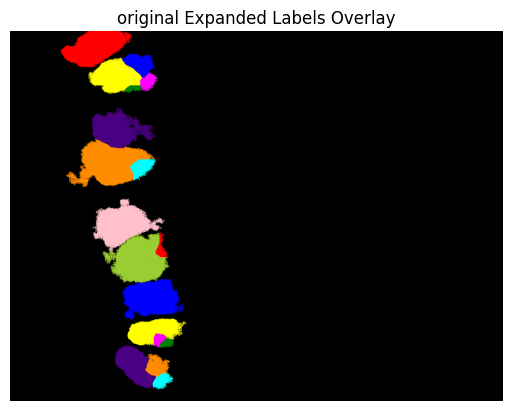

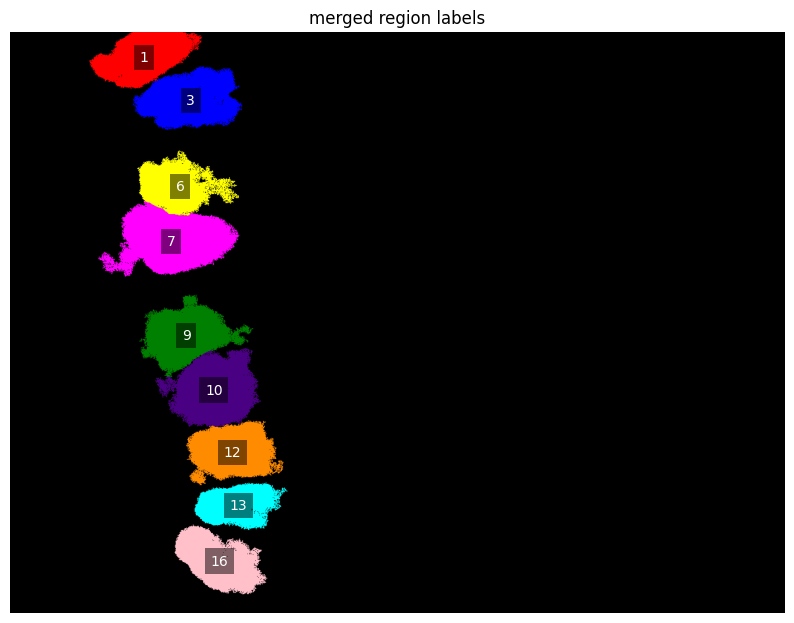

In [5]:
#compute_stats_and_adjacency
import numpy as np
from skimage.measure import regionprops, perimeter
from skimage.morphology import dilation, rectangle
from itertools import combinations
from collections import defaultdict

import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.measure import regionprops

def compute_stats_and_adjacency(label_img):
    props    = {r.label: r for r in regionprops(label_img)}
    perims   = {lbl: perimeter(label_img == lbl) for lbl in props}
    centroids= {lbl: props[lbl].centroid for lbl in props}
    areas    = {lbl: props[lbl].area     for lbl in props}
    
    # adjacency: shared perimeter between i↔j
    shared = defaultdict(lambda: defaultdict(int))
    for lbl in props:
        mask = label_img == lbl
        dil  = dilation(mask, rectangle(3,3))
        neighs = set(np.unique(label_img[dil])) - {0, lbl}
        for n in neighs:
            shared_p = int(np.logical_and(dil, label_img==n).sum())
            shared[lbl][n] = shared_p
            shared[n][lbl] = shared_p
    
    return props, perims, centroids, areas, shared

props, perims, cents, areas, shared = compute_stats_and_adjacency(expanded_labels)
print("Properties:", props)
print(shared)
#find_triangles
from collections import defaultdict
from itertools import combinations

def find_triangles(shared_adjacency):
    """
    Given a shared adjacency dictionary {label: {neighbor_label: shared_perimeter}},
    find all unique 3-cliques (triangles) where all three labels are mutually connected.
    
    Returns:
        triangles: List of tuples (a, b, c) where a, b, c are labels in a triangle.
    """
    triangles = set()
    for a in shared_adjacency:
        neighbors_a = set(shared_adjacency[a])
        for b, c in combinations(neighbors_a, 2):
            if b in shared_adjacency[c] and c in shared_adjacency[b]:
                triangle = tuple(sorted((a, b, c)))
                triangles.add(triangle)
    return sorted(triangles)

# # Example usage mock
# example_shared = {
#     1: {2: 5, 3: 5},
#     2: {1: 5, 3: 5},
#     3: {1: 5, 2: 5},
#     4: {5: 5},
#     5: {4: 5}
# }# note the :5 is a placeholder for shared perimeter, not used in this function

# triangles = find_triangles(example_shared)

# Example usage with actual shared adjacency
triangles = find_triangles(shared)
print("Triangles found:", triangles)

#build_candidate_groups
# remeber this ingnores labels that have no sharing, so need to reintegrate them later
def build_candidate_groups(shared, triangles, singleton_penalty=5.0):
    """
    For each label, generate all valid merge candidate groups:
    - Self group
    - Direct 2-member cliques
    - 3-member triangles
    - Chained triangles (sharing 2 nodes including current label)
    """
    # reverse index triangles by label
    triangle_index = defaultdict(list)
    for tri in triangles:
        for lbl in tri:
            triangle_index[lbl].append(tri)

    combos_by_label = defaultdict(list)
    for lbl in shared:
        # (1) Self combo
        combos_by_label[lbl].append((lbl,))

        # (2) 2-element combos
        for n in shared[lbl]:
            if n != lbl:
                # direct, directional pairings (had to get rid of deduplication bc it was making labels ignorant of merge options
                combos_by_label[lbl].append((lbl, n))

        # (3) 3-element triangles
        combos_by_label[lbl].extend(triangle_index[lbl])

        # (4) Extended groups via chained triangles
        seen = set()
        for tri1 in triangle_index[lbl]:
            for tri2 in triangle_index[lbl]:
                if tri1 == tri2:
                    continue
                inter = set(tri1).intersection(tri2)
                if len(inter) == 2 and lbl in inter:
                    merged = tuple(sorted(set(tri1).union(tri2)))
                    if merged not in seen:
                        combos_by_label[lbl].append(merged)
                        seen.add(merged)

    return combos_by_label
combos = build_candidate_groups(shared, triangles)
print("Combos by label:", combos)

def evaluate_first_stage_merges(combos_by_label, perims, shared, singleton_penalty=10.0):
    """
    Returns the best merge candidate for each label based on:
    - (total shared perimeter with group) / (total exposed perimeter)
    """
    best_combo_by_label = {}
    for lbl, combo_list in combos_by_label.items():
        P = perims[lbl]
        best_score = -1.0
        best_combo = (lbl,)
        for combo in combo_list:
            if combo == (lbl,):
                score = 1.0 / singleton_penalty
            else:
                shared_sum = sum(shared[lbl][n] for n in combo if n != lbl)
                score = shared_sum / (P + 1e-8)
            if score > best_score:
                best_score = score
                best_combo = combo
        best_combo_by_label[lbl] = (best_combo, best_score)
    return best_combo_by_label
best_stage1 = evaluate_first_stage_merges(combos, perims, shared)
print("Best first stage merges:", best_stage1)

#assign_group_leaders
from collections import defaultdict
import math
import numpy as np


def assign_group_leaders(best_stage1, areas, ifdebug=False):
    """
    Assigns a leader for each group determined in best_stage1.

    Args:
        best_stage1 (dict): label -> (group_tuple, score)
        areas (dict): label -> area
        ifdebug (bool): when True, print step-by-step diagnostics

    Returns:
        group_map (defaultdict): normalized_group_tuple -> set of labels pointing to that group
        group_leaders (dict): normalized_group_tuple -> leader label (largest area)
        label_to_group (dict): label -> normalized_group_tuple
    """
    group_map = defaultdict(set)
    label_to_group = {}

    # 1) Build mappings
    if ifdebug:
        print("=== 1) Normalizing groups and building mappings ===")
    for label, (group, score) in best_stage1.items():
        norm_group = tuple(sorted(int(g) for g in group))
        if ifdebug:
            print(f"Label {label!r}: raw group={group} -> normalized={norm_group}")
        group_map[norm_group].add(int(label))
        label_to_group[int(label)] = norm_group

    # Optional debug print of maps
    if ifdebug:
        print("\n=== 2) group_map contents ===")
        for grp, members in group_map.items():
            print(f"Group {grp!r}: pointed-to by {sorted(members)}")
        print("\n=== 3) label_to_group mapping ===")
        for lbl in sorted(label_to_group):
            print(f"Label {lbl!r} -> group {label_to_group[lbl]!r}")

    # 2) Choose leader from the group definition itself
    group_leaders = {}
    if ifdebug:
        print("\n=== 4) Selecting group leaders ===")
    for grp in group_map:
        candidate_members = list(grp)
        if ifdebug:
            areas_dict = {m: areas.get(m) for m in candidate_members}
            print(f"Group {grp!r} candidates={candidate_members} with areas={areas_dict}")
        leader = max(candidate_members, key=lambda x: areas[x])
        if ifdebug:
            print(f"  -> chosen leader={leader!r} (area={areas[leader]})")
        group_leaders[grp] = leader

    # Final debug
    if ifdebug:
        print("\n=== 5) Final label_to_group mapping ===")
        for lbl in sorted(label_to_group):
            print(f"Label {lbl!r} -> group {label_to_group[lbl]!r}")
        print("=== Debug complete ===")

    return group_map, group_leaders, label_to_group

group_map, group_leaders, label_to_group = assign_group_leaders(best_stage1, areas)



def expand_neighbors(group, shared, visited=None):
    if visited is None:
        visited = set(group)
    for label in list(visited):
        for neighbor in shared[label]:
            if neighbor not in visited:
                visited.add(neighbor)
                expand_neighbors(group, shared, visited)
    return visited



def compute_stage2_score(label, group, areas, perims, props, group_leader, sample_size=100, eps=1e-8):
    total_area = sum(areas[l] for l in group)
    total_perim = sum(perims[l] for l in group)
    coords = np.vstack([props[l].coords for l in group])
    group_centroid = coords.mean(axis=0)

    # Sample points from label and compute mean distance to group COM
    label_coords = props[label].coords
    if len(label_coords) > sample_size:
        indices = np.linspace(0, len(label_coords) - 1, sample_size).astype(int)
        label_sample = label_coords[indices]
    else:
        label_sample = label_coords
    dists = np.linalg.norm(label_sample - group_centroid, axis=1)
    avg_dist = dists.mean()

    score = (total_area / (total_perim + eps)) / (avg_dist + eps)
    return score



def evaluate_second_stage_merges(best_stage1, shared, props, areas, perims, sample_size=100):
    group_map, group_leaders, label_to_group = assign_group_leaders(best_stage1, areas)

    second_stage_results = {}

    for group, members in group_map.items():
        leader = group_leaders[group]
        # Build candidate group: start with group members
        expanded_group = set(group)

        # Add direct neighbors of group labels
        for l in group:
            expanded_group.update(shared[l].keys())

        # Filter to only labels present in props
        expanded_group = {int(lbl) for lbl in expanded_group if int(lbl) in props}

        for label in members:
            score = compute_stage2_score(
                label, expanded_group, areas, perims, props, leader, sample_size=sample_size
            )
            second_stage_results[label] = (leader, score)

    # Add untouched singletons (not in best_stage1 or were self-only)
    all_labels = set(props.keys())
    processed_labels = set(second_stage_results.keys())
    unprocessed = all_labels - processed_labels

    for label in unprocessed:
        second_stage_results[int(label)] = (int(label), 0.0)  # No merge

    return second_stage_results


# This function is now ready to be run with:
#   best_stage1: Dict[int, Tuple[int,...]]
#   shared, props, areas, perims: from compute_stats_and_adjacency
# Produces:
#   second_stage_results[label] = (final_merge_target, score)
second_stage_results = evaluate_second_stage_merges(best_stage1, shared, props, areas, perims)
print("Second stage results:", second_stage_results)

import numpy as np

def relabel_from_merge_map(label_img: np.ndarray, second_stage_results: dict[int, tuple[int, float]]) -> np.ndarray:
    """
    Reassign labels in the image based on the second-stage merge map.

    Args:
        label_img: Original labeled image (2D np.ndarray of ints)
        second_stage_results: Dict[label] = (final_merge_target_label, score)

    Returns:
        relabeled_img: New labeled image with merged groups
    """
    # Create a mapping from old label → new label
    label_mapping = {int(lbl): int(merge_target) for lbl, (merge_target, _) in second_stage_results.items()}

    # Initialize output with zeros
    relabeled_img = np.zeros_like(label_img)

    for old_lbl, new_lbl in label_mapping.items():
        relabeled_img[label_img == old_lbl] = new_lbl

    return relabeled_img

merged_label_array = relabel_from_merge_map(expanded_labels, second_stage_results)

colored = label2rgb(expanded_labels, bg_label=0)
plt.imshow(colored)
plt.title("original Expanded Labels Overlay")
plt.axis('off')
plt.show()


def plot_labels_with_numbers(label_array, background=0, title="merged region labels"):
    # Create a color image
    colored = label2rgb(label_array, bg_label=background)

    # Display the color image
    plt.figure(figsize=(10, 10))
    plt.imshow(colored)
    plt.title(title)
    plt.axis('off')

    # Overlay label numbers at centroids
    for region in regionprops(label_array):
        if region.label == background:
            continue
        y, x = region.centroid
        plt.text(x, y, str(region.label), color='white', fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor='black', alpha=0.5, lw=0))

    plt.show()
plot_labels_with_numbers(merged_label_array)
